# 94-775/95-865: Sentiment Analysis with IMDb Reviews

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo shows how to train an LSTM model for sentiment analysis with IMDB reviews. This is a binary classification task: for each review, we classify it as having positive or negative sentiment.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

# the next two lines are needed on my Intel-based MacBook Air to get the code to run; you likely don't need these two lines...
# (in fact I used to not need these two lines)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import torch
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False
import torch.nn as nn
from torchsummaryX import summary

from UDA_pytorch_utils import UDA_LSTMforSequential, UDA_pytorch_classifier_fit, \
    UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
    UDA_compute_accuracy

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

## Load the dataset

In [2]:
from torchnlp.datasets import imdb_dataset
torch.manual_seed(0)

In [3]:
train_dataset = imdb_dataset(train=True)

In [4]:
len(train_dataset)

25000

In [5]:
proper_train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - proper_train_size

In [6]:
proper_train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,
                                                                  [proper_train_size,
                                                                   val_size])

In [7]:
proper_train_dataset[1]

{'text': '"Heartland" is a wonderful depiction of what it was really like to live on the frontier. The hard work and individual strength that were needed to survive the hardships of the climate and the lack of medical care are blended with the camaraderie and the interdependence of the settlers. The drama was especially meaningful because the story is based on the diaries of real people whose descendants still live there. It was also nice to see the west inhabited by real people. No one was glamorous or looked as if they had just spent a session with the makeup or costume department. Conchatta Ferrell is just wonderful. She is an example of the strong, persevering people who came to Wyoming in the early 20th century and let no hardship stand in their way of a new life in a new land.',
 'sentiment': 'pos'}

In [8]:
from torchnlp.encoders.text import SpacyEncoder

In [9]:
encoder = SpacyEncoder([data['text'] for data in proper_train_dataset])

In [10]:
proper_train_encoded = [encoder.encode(data['text']) for data in proper_train_dataset]

In [11]:
proper_train_encoded[1]

tensor([  5, 266,   5,  50,  14, 267, 268,  37,  22,  87,  88,  70, 269,  23,
        270,  33,  47, 271,  16,   6, 272, 273,  31, 274, 275, 109, 276, 277,
         23, 278,  47, 279,  37,  47, 280,  31,  47, 281,  37, 282, 283, 284,
        285,  85,  47, 286,  31,  47, 287,  37,  47, 288,  16,   6, 289,  88,
        290, 291, 130,  47, 292,  50,  32,  33,  47, 293,  37, 294, 295, 210,
        296, 297, 270, 206,  16, 298,  88, 299, 300,  23, 301,  47, 302, 303,
         27, 294, 295,  16, 304,  36,  88, 305, 306, 307,  13, 308, 185,  18,
        309, 310,  14, 311,  85,  47, 312, 306, 313, 314,  16, 315, 316,  50,
        309, 267,  16, 232,  50,  98, 317,  37,  47, 134,  30, 318, 295, 132,
         11,  23, 319,  12,  47, 320, 321, 322,  31, 323,  19, 324, 325,  12,
        223, 181,  37,  14, 326,  67,  12,  14, 326, 327,  16])

In [12]:
print([encoder.vocab[word_idx] for word_idx in proper_train_encoded[1]])

['"', 'Heartland', '"', 'is', 'a', 'wonderful', 'depiction', 'of', 'what', 'it', 'was', 'really', 'like', 'to', 'live', 'on', 'the', 'frontier', '.', 'The', 'hard', 'work', 'and', 'individual', 'strength', 'that', 'were', 'needed', 'to', 'survive', 'the', 'hardships', 'of', 'the', 'climate', 'and', 'the', 'lack', 'of', 'medical', 'care', 'are', 'blended', 'with', 'the', 'camaraderie', 'and', 'the', 'interdependence', 'of', 'the', 'settlers', '.', 'The', 'drama', 'was', 'especially', 'meaningful', 'because', 'the', 'story', 'is', 'based', 'on', 'the', 'diaries', 'of', 'real', 'people', 'whose', 'descendants', 'still', 'live', 'there', '.', 'It', 'was', 'also', 'nice', 'to', 'see', 'the', 'west', 'inhabited', 'by', 'real', 'people', '.', 'No', 'one', 'was', 'glamorous', 'or', 'looked', 'as', 'if', 'they', 'had', 'just', 'spent', 'a', 'session', 'with', 'the', 'makeup', 'or', 'costume', 'department', '.', 'Conchatta', 'Ferrell', 'is', 'just', 'wonderful', '.', 'She', 'is', 'an', 'example'

In [13]:
proper_train_labels = torch.tensor([int(data['sentiment'] == 'pos')
                                    for data in proper_train_dataset])

In [14]:
val_encoded = [encoder.encode(data['text']) for data in val_dataset]

In [15]:
val_labels = torch.tensor([int(data['sentiment'] == 'pos') for data in val_dataset])

In [16]:
proper_train_dataset_encoded = list(zip(proper_train_encoded, proper_train_labels))
val_dataset_encoded = list(zip(val_encoded, val_labels))

## Setting up a recurrent neural net for sentiment analysis that uses pre-trained word embeddings

We first load in pre-trained GloVe embeddings only for tokens that we encountered in the proper training data.

In [17]:
from torchnlp.word_to_vector import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)

In [18]:
type(pretrained_embedding)

torchnlp.word_to_vector.glove.GloVe

In [19]:
pretrained_embedding['cat']

tensor([ 0.2309,  0.2828,  0.6318, -0.5941, -0.5860,  0.6326,  0.2440, -0.1411,
         0.0608, -0.7898, -0.2910,  0.1429,  0.7227,  0.2043,  0.1407,  0.9876,
         0.5253,  0.0975,  0.8822,  0.5122,  0.4020,  0.2117, -0.0131, -0.7162,
         0.5539,  1.1452, -0.8804, -0.5022, -0.2281,  0.0239,  0.1072,  0.0837,
         0.5501,  0.5848,  0.7582,  0.4571, -0.2800,  0.2522,  0.6896, -0.6097,
         0.1958,  0.0442, -0.3114, -0.6883, -0.2272,  0.4618, -0.7716,  0.1021,
         0.5564,  0.0674, -0.5721,  0.2374,  0.4717,  0.8277, -0.2926, -1.3422,
        -0.0993,  0.2814,  0.4160,  0.1058,  0.6220,  0.8950, -0.2345,  0.5135,
         0.9938,  1.1846, -0.1636,  0.2065,  0.7385,  0.2406, -0.9647,  0.1348,
        -0.0072,  0.3302, -0.1236,  0.2719, -0.4095,  0.0219, -0.6069,  0.4076,
         0.1957, -0.4180,  0.1864, -0.0327, -0.7857, -0.1385,  0.0440, -0.0844,
         0.0491,  0.2410,  0.4527, -0.1868,  0.4618,  0.0891, -0.1819, -0.0152,
        -0.7368, -0.1453,  0.1510, -0.71

In [20]:
embedding_weights = torch.empty(encoder.vocab_size, pretrained_embedding.dim)
for i, token in enumerate(encoder.vocab):
    embedding_weights[i] = pretrained_embedding[token]

In [21]:
simple_lstm_model = nn.Sequential(nn.Embedding.from_pretrained(embedding_weights),
                                  UDA_LSTMforSequential(100, 64),
                                  nn.Linear(64, 2))

In [22]:
summary(simple_lstm_model, torch.zeros((1, 5), dtype=torch.long))

                 Kernel Shape Output Shape   Params Mult-Adds
Layer                                                        
0_0             [100, 108380]  [1, 5, 100]        -         -
1_1.LSTM_model              -   [1, 5, 64]  42.496k   41.984k
2_2                   [64, 2]       [1, 2]    130.0     128.0
--------------------------------------------------------------
                          Totals
Total params          10.880626M
Trainable params         42.626k
Non-trainable params     10.838M
Mult-Adds                42.112k


/Users/georgehc/opt/anaconda3/lib/python3.9/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[100, 108380]","[1, 5, 100]",NaN,NaN
1_1.LSTM_model,-,"[1, 5, 64]",42496.0,41984.0
2_2,"[64, 2]","[1, 2]",130.0,128.0


In [23]:
os.makedirs('./saved_model_checkpoints', exist_ok=True)

Epoch 1 [==================================================] 20000/20000
  Train accuracy: 0.7994
  Validation accuracy: 0.7858
Epoch 2 [==================================================] 20000/20000
  Train accuracy: 0.8462
  Validation accuracy: 0.8366
Epoch 3 [==================================================] 20000/20000
  Train accuracy: 0.7997
  Validation accuracy: 0.8016
Epoch 4 [==================================================] 20000/20000
  Train accuracy: 0.8569
  Validation accuracy: 0.8384
Epoch 5 [==================================================] 20000/20000
  Train accuracy: 0.8820
  Validation accuracy: 0.8564
Epoch 6 [==================================================] 20000/20000
  Train accuracy: 0.8926
  Validation accuracy: 0.8630
Epoch 7 [==================================================] 20000/20000
  Train accuracy: 0.9039
  Validation accuracy: 0.8660
Epoch 8 [==================================================] 20000/20000
  Train accuracy: 0.9005
  Vali

  Validation accuracy: 0.5242
Epoch 65 [==================================================] 20000/20000
  Train accuracy: 0.7853
  Validation accuracy: 0.7740
Epoch 66 [==================================================] 20000/20000
  Train accuracy: 0.7916
  Validation accuracy: 0.7798
Epoch 67 [==================================================] 20000/20000
  Train accuracy: 0.6038
  Validation accuracy: 0.6058
Epoch 68 [==================================================] 20000/20000
  Train accuracy: 0.6278
  Validation accuracy: 0.6210
Epoch 69 [==================================================] 20000/20000
  Train accuracy: 0.6282
  Validation accuracy: 0.6226
Epoch 70 [==================================================] 20000/20000
  Train accuracy: 0.6432
  Validation accuracy: 0.6380
Epoch 71 [==================================================] 20000/20000
  Train accuracy: 0.6517
  Validation accuracy: 0.6454
Epoch 72 [==================================================] 20000

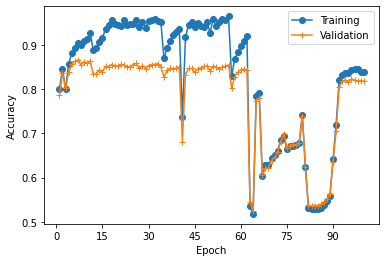

In [24]:
num_epochs = 100  # during optimization, how many times we look at training data
batch_size = 64  # during optimization, how many training data to use at each step
learning_rate = 0.005  # during optimization, how much we nudge our solution at each step

train_accuracies, val_accuracies = \
    UDA_pytorch_classifier_fit(simple_lstm_model,
                               torch.optim.Adam(simple_lstm_model.parameters(),
                                                lr=learning_rate),
                               nn.CrossEntropyLoss(),  # includes softmax
                               proper_train_dataset_encoded, val_dataset_encoded,
                               num_epochs, batch_size,
                               sequence=True,
                               save_epoch_checkpoint_prefix='./saved_model_checkpoints/imdb_lstm')

UDA_plot_train_val_accuracy_vs_epoch(train_accuracies, val_accuracies)

In [25]:
best_epoch_idx = np.argmax(val_accuracies)
print('The model at the end of epoch %d achieved the highest validation accuracy: %f'
      % (best_epoch_idx + 1, val_accuracies[best_epoch_idx]))
simple_lstm_model.load_state_dict(torch.load('./saved_model_checkpoints/imdb_lstm_epoch%d.pt' % (best_epoch_idx + 1)))

The model at the end of epoch 7 achieved the highest validation accuracy: 0.866000


<All keys matched successfully>

## Finally evaluate on test data

In [26]:
test_dataset = imdb_dataset(train=False, test=True)

In [27]:
test_encoded = [encoder.encode(data['text']) for data in test_dataset]

In [28]:
test_labels = torch.tensor([int(data['sentiment'] == 'pos') for data in test_dataset])

In [29]:
predicted_test_labels = UDA_pytorch_classifier_predict(simple_lstm_model,
                                                       test_encoded,
                                                       sequence=True)

In [30]:
print('Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_labels))

Test accuracy: 0.86952


In [31]:
UDA_pytorch_classifier_predict(simple_lstm_model,
                               [encoder.encode('this movie rocks')],
                               sequence=True)

tensor([1])

In [32]:
UDA_pytorch_classifier_predict(simple_lstm_model,
                               [encoder.encode('this movie sucks')],
                               sequence=True)

tensor([0])

In [33]:
UDA_pytorch_classifier_predict(simple_lstm_model,
                               [encoder.encode('this sucks')],
                               sequence=True)

tensor([0])